In [1]:
from predict import getMask
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
import style.utils as utils
from style.CLIPstyler import getStyleImg
from torchvision import transforms, models
import torch.nn.functional as F
import clip
from style.template import imagenet_templates
from PIL import Image
import random
import itertools


/home/web428/anaconda3/envs/soulstyler/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_path = "./testimg/ship.jpg"
config_path = "./config/refcoco+/test.yaml"
model_pth = "./best_model.pth"

sent = "the a white with sails on blue"
sent = "a white boat with blue sails on the sea"
sent = "A white boat with blue sails gracefully sails across the sea."
sent = "The boat is a magnificent vessel adorned with three majestic blue sails. Its towering and grand hull commands attention and awe. The pristine white body gleams with a smooth coating, shimmering in the sunlight. Each piece of blue fabric unfurled on the masts exhibits a deep and vibrant shade, creating a striking contrast against the surrounding sea. The sails are securely fastened to the masts with delicate ropes, billowing and dancing in the wind, as if embarking on a journey to the unknown. The beauty and grandeur of this boat are captivating, making it a shining star upon the vast ocean."
sent = "A white sailboat with three blue sails floating on the sea"


In [3]:
def getMaskImg(img,config_path,model_pth,sent=None):
    img_style1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_style2 = img_style1/255.0
    img_style3 = np.transpose(img_style2, (2,0,1))
    img_style4 = torch.Tensor(img_style3)
    img_style = torch.unsqueeze(img_style4, 0)

    mask0 = getMask(img,sent,config_path,model_pth)
    mask1 = np.stack((mask0, mask0,mask0), axis=2)
    mask_img = np.array(mask1*255, dtype=np.uint8)
    return mask_img

def load_image(img,mode="PLT"):
    if mode == "CV":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
                        transforms.ToTensor(),
                        ])   
    image = transform(img)[:3, :, :].unsqueeze(0)
    return image

def squeeze_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)
    image = torch.Tensor(image)
    return image

def getCropsInMask(img,mask,size,batch):
    pot_crop = []
    cropper = transforms.RandomCrop(size)
    while len(pot_crop)<batch  :
        (i, j, h, w) = cropper.get_params(squeeze_convert(mask), (size, size))
        mask_crop = transforms.functional.crop(mask, i, j, h, w)
        img_crop = transforms.functional.crop(img, i, j, h, w)
        if int(mask_crop[0].sum())/(3*size*size) >= 0.9:
            if len(pot_crop)<batch :
                pot_crop.append(img_crop)
    return pot_crop

def clip_normalize2(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    return image

def getCrops(img,size,batch):
    crops = []
    cropper = transforms.RandomCrop(size)
    
    #获取足够数量的物体裁剪照片
    while len(crops)<batch  :
        (i, j, h, w) = cropper.get_params(squeeze_convert(img), (size, size))
        img_crop = transforms.functional.crop(img, i, j, h, w)
        crops.append(img_crop)
    return crops

def getLoss(text_feature,img_feature):
    return 1-torch.cosine_similarity(text_feature, img_feature)

def getClipImgFeature(image,clip_model):
    image = F.interpolate(image,size=224,mode='bicubic')
    image = clip_model.encode_image(image.to(device))
    image /= image.norm(dim=-1, keepdim=True)
    return image

def img_normalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def getVggFeature(image,device,VGG):
    return utils.get_features(img_normalize(image), VGG)

def getVggFeatureLossMES(image,target):
    content_loss = 0
    content_loss += torch.mean((target['conv4_2'] - image['conv4_2']) ** 2)
    content_loss += torch.mean((target['conv5_2'] - image['conv5_2']) ** 2)
    
    return content_loss


In [4]:
clip_model, _ = clip.load('ViT-B/32', device, jit=False)
VGG = models.vgg19(pretrained=True).features
VGG.to(device)
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

2023-06-11 00:07:23.944 | INFO     | model:build_segmenter:46 - Backbone with decay=325, Head=124


vis.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis2.shape=torch.Size([676, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis2.shape=torch.Size([676, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis2.shape=torch.Size([676, 1, 512])
vis_pos.shape=torch.Size([676, 1, 51

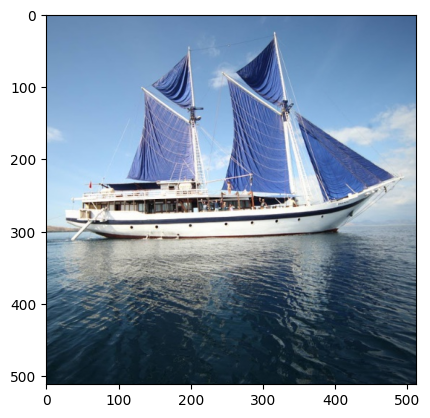

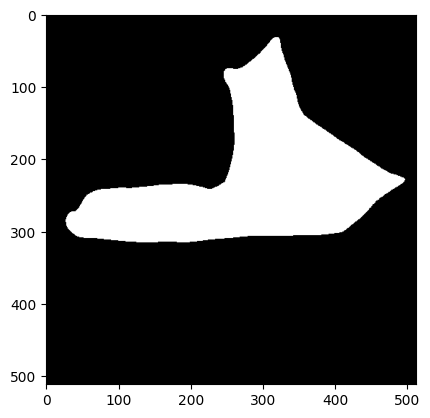

In [5]:
img = cv2.imread(img_path)
mask = getMaskImg(img,config_path,model_pth,sent)

img = load_image(img,mode="CV").to(device)
mask = load_image(mask)

plt.imshow(utils.im_convert2(img))
plt.show()
plt.imshow(utils.im_convert2(mask))
plt.show()

In [6]:
images = getCropsInMask(img,mask,64,64)


In [7]:
getMask(img.clone(),sent,config_path,model_pth)

2023-06-11 00:07:33.736 | INFO     | model:build_segmenter:46 - Backbone with decay=325, Head=124
2023-06-11 00:07:36.398 | ERROR    | __main__:<module>:1 - An error has been caught in function '<module>', process 'MainProcess' (16617), thread 'MainThread' (140059738476928):
Traceback (most recent call last):

  File "/home/web428/anaconda3/envs/soulstyler/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
           │         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
           │         └ <code object <module> at 0x7f6231f9ab30, file "/home/web428/anaconda3/envs/soulstyler/lib/python3.8/site-packages/ipykernel_l...
           └ <function _run_code at 0x7f6231f7e550>
  File "/home/web428/anaconda3/envs/soulstyler/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__':

In [10]:
from style import StyleNet
style_net = StyleNet.UNet()
style_net.to(device)
optimizer = torch.optim.Adam(style_net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
for epoch in range(300):
    scheduler.step()
    target = style_net(img,use_sigmoid=True).to(device)
    target.requires_grad_(True)
    _mask = getMask(target.clone(),sent,config_path,model_pth)
    print(_mask)

2022-11-04 23:03:51.019 | INFO     | model:build_segmenter:46 - Backbone with decay=325, Head=127
2022-11-04 23:04:03.632 | ERROR    | __main__:<cell line: 6>:10 - An error has been caught in function '<cell line: 6>', process 'MainProcess' (41512), thread 'MainThread' (46644):
Traceback (most recent call last):

  File "c:\setup\python\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
           │         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
           │         └ <code object <module> at 0x000001CCD5AE3BE0, file "c:\setup\python\lib\site-packages\ipykernel_launcher.py", line 1>
           └ <function _run_code at 0x000001CCD5C20310>

  File "c:\setup\python\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate fro

None


2022-11-04 23:04:22.197 | INFO     | model:build_segmenter:46 - Backbone with decay=325, Head=127
2022-11-04 23:04:23.446 | ERROR    | __main__:<cell line: 6>:10 - An error has been caught in function '<cell line: 6>', process 'MainProcess' (41512), thread 'MainThread' (46644):
Traceback (most recent call last):

  File "c:\setup\python\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
           │         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
           │         └ <code object <module> at 0x000001CCD5AE3BE0, file "c:\setup\python\lib\site-packages\ipykernel_launcher.py", line 1>
           └ <function _run_code at 0x000001CCD5C20310>

  File "c:\setup\python\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate fro

None


2022-11-04 23:04:44.974 | INFO     | model:build_segmenter:46 - Backbone with decay=325, Head=127


KeyboardInterrupt: 